<a href="https://colab.research.google.com/github/bharaniakella/Akellian_DL/blob/main/l1_regularization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# import libraries
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

#
from torch.utils.data import DataLoader

In [2]:
# import dataset
import pandas as pd
iris = pd.read_csv('https://raw.githubusercontent.com/mwaskom/seaborn-data/master/iris.csv')

In [3]:
# organize the data

# convert from pandas dataframe to tensor
data = torch.tensor( iris[iris.columns[0:4]].values ).float()

# transform species to number
labels = torch.zeros(len(data), dtype=torch.long)
# labels[iris.species=='setosa']   = 0 # don't need!
labels[iris.species=='versicolor'] = 1
labels[iris.species=='virginica']  = 2

In [4]:
# use scikitlearn to split the data
train_data,test_data, train_labels,test_labels = train_test_split(data, labels, test_size=.2)

# then convert them into PyTorch Datasets (note: already converted to tensors)
train_dataDataset = torch.utils.data.TensorDataset(train_data,train_labels)
test_dataDataset  = torch.utils.data.TensorDataset(test_data,test_labels)

# create dataloader objects
train_loader = DataLoader(train_dataDataset,batch_size=64, shuffle=True, drop_last=True)
test_loader  = DataLoader(test_dataDataset,batch_size=test_dataDataset.tensors[0].shape[0])

In [6]:
# a function that creates the ANN model

def createANewModel():

  # model architecture
  ANNiris = nn.Sequential(
      nn.Linear(4,64),   # input layer
      nn.ReLU(),         # activation unit
      nn.Linear(64,64),  # hidden layer
      nn.ReLU(),         # activation unit
      nn.Linear(64,3),   # output units
        )

  # loss function
  lossfun = nn.CrossEntropyLoss()

  # optimizer
  optimizer = torch.optim.SGD(ANNiris.parameters(),lr=.005)

  return ANNiris,lossfun,optimizer

In [11]:
numepochs = 1000

def trainTheModel(L1lambda):
  trainAcc = []
  testAcc  = []
  losses   = []

  nweights=0
  for pname,weight in ANNiris.named_parameters():
    if 'bias' not in pname:
      nweights=nweights+weight.numel()


  for epochi in range(numepochs):
    batchAcc=[]
    batchLoss=[]
    for x,y in train_loader:
      yHat=ANNiris(x)
      loss=lossfun(yHat,y)

      L1term=torch.tensor(0.,requires_grad=True)
      for pname,weight in ANNiris.named_parameters():
        if 'bias' not in pname:
          L1term=L1term+torch.sum(torch.abs(weight))

      loss=loss + L1lambda*L1term/nweights

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()


      batchAcc.append( 100*torch.mean((torch.argmax(yHat,axis=1) == y).float()).item() )
      batchLoss.append( loss.item() )

    trainAcc.append( np.mean(batchAcc) )
    losses.append( np.mean(batchLoss) )

    X,y = next(iter(test_loader))
    predlabels = torch.argmax( ANNiris(X),axis=1 )
    testAcc.append( 100*torch.mean((predlabels == y).float()).item() )

  # function output
  return trainAcc,testAcc,losses


In [12]:
# create a model
ANNiris,lossfun,optimizer = createANewModel()

# train the model
L1lambda = .001
trainAcc,testAcc,losses = trainTheModel(L1lambda)

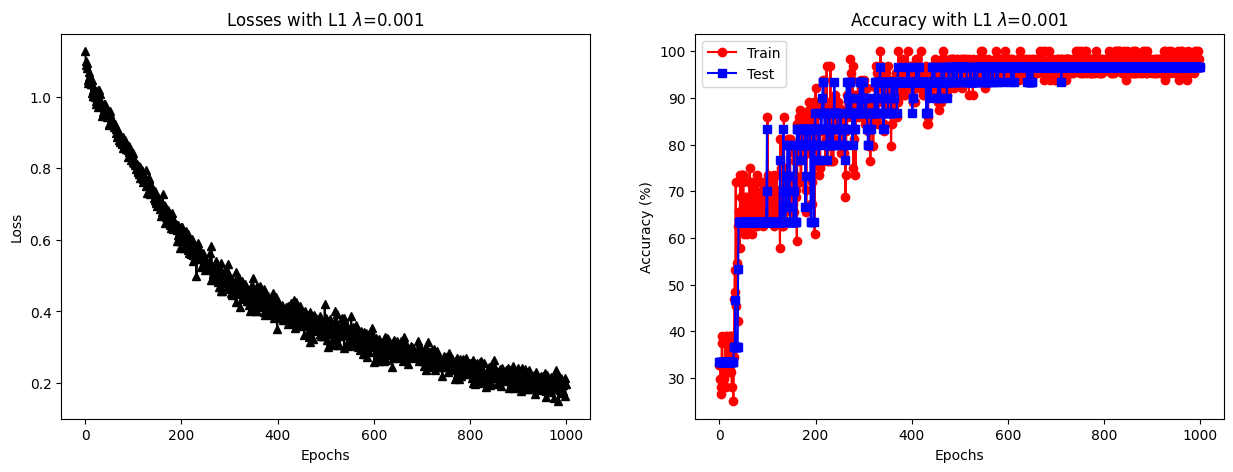

In [13]:
# plot the results
fig,ax = plt.subplots(1,2,figsize=(15,5))


ax[0].plot(losses,'k^-')
ax[0].set_ylabel('Loss')
ax[0].set_xlabel('Epochs')
ax[0].set_title('Losses with L1 $\lambda$=' + str(L1lambda))

ax[1].plot(trainAcc,'ro-')
ax[1].plot(testAcc,'bs-')
ax[1].set_title('Accuracy with L1 $\lambda$=' + str(L1lambda))
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy (%)')
ax[1].legend(['Train','Test'])

plt.show()